In [1]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt

  Using cached https://files.pythonhosted.org/packages/75/14/fde90de4fc6722303ddbc183ec253c288dae8c7e4eb5a069ac49f14c9a0f/scikit_learn-0.21.2-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/53/17/9dfd64540b6645fae581462ed2d1c8e680b7e946ca2789c5149693660392/scipy-1.3.0-cp37-cp37m-win_amd64.whl
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.arima_model import AR
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Functions Used

In [3]:
def scale_and_separate(df, labels=True):
    """
    Function that applies normalization to the data by subtracting the mean and dividing by the std for every
    observation in each column
    :param df: the initial dataframe
    :param labels: if there are attack labels in the dataset
    :return: the scaled dataset with the labels separated (if existed)
    """
    df.columns = df.columns.str.lstrip()
    y = None
    if labels:
        y = df['ATT_FLAG']  # separate the target values
        df.drop(['ATT_FLAG'], axis=1, inplace=True)

    # apply scaling
    scaled_df = pd.DataFrame(StandardScaler().fit_transform(df.values), index=df.index, columns=df.columns)
    return scaled_df, y

In [17]:
def make_heatmap(df, dataset, remove_constant=False):
    """
    Function that creates the correlation heatmap of the signals in the dataset
    :param df: the dataframe to be checked
    :param dataset: the type of the dataset
    :param remove_constant: bool value indicating if constant signals should be removed from the heatmap
    :return: creates and saves the correlation heatmap
    """
    sns.set(style="white")
    
    temp_df = df.copy()
    # remove constant values
    if remove_constant:
        constants = [x for x in temp_df if np.std(temp_df[x]) == 0]
        temp_df.drop(columns=constants, inplace=True)

    # Compute the correlation matrix
    corr = temp_df.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap,
                square=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values,
                linewidths=0.5, cbar_kws={"shrink": .5}, ax=ax)

    if remove_constant:
#         plt.savefig('plots/%s/heatmap_no_constants.png' % dataset, bbox_inches='tight')
        plt.show()
    else:
#         plt.savefig('plots/%s/heatmap.png' % dataset, bbox_inches='tight')
        plt.show()

In [18]:
def make_lineplot(df, features, dataset, start_date, end_date):
    """
    Function that produces the lineplots for the visualization of the signals
    :param df: the dataframe with the signals
    :param features: which signals to plot
    :param dataset: the type of the dataset (training or test set)
    :param start_date: the starting date in the plot
    :param end_date: the ending date in the plot
    :return: creates and saves the produced lineplot
    """
    fig, ax = plt.subplots(len(features), 1, sharex=True)
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    for ind, feature in enumerate(features):
        ax[ind].plot(df.loc[start_date:end_date][feature], colors[ind])
        ax[ind].xaxis.set_major_locator(mdates.DayLocator([5, 10, 15, 20, 25, 30]))
        ax[ind].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        ax[ind].set_ylabel(feature)
        ax[ind].grid()
    plt.xticks(rotation=45)
    plt.xlabel("time")
    if len(features) > 1:
#         plt.savefig('plots/%s/lineplot_%s.png' % (dataset, '_'.join(features)), bbox_inches='tight')
        plt.show()
    else:
#         plt.savefig('plots/%s/lineplot_%s.png' % (dataset, features[0]), bbox_inches='tight')
        plt.show()

In [19]:
def predict_AR(test, history, window, coeff):
    """
    Function that uses a fitted AR model to predict the values in test
    :param test: the series to be predicted
    :param history: the history list to be used for the prediction
    :param window: the window to check in the past (p parameter of the AR model)
    :param coeff: the coefficients of the fitted AR model
    :return: the prediction made in a Series object
    """
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length - window, length)]  # keep the last window values
        yhat = coeff[0]
        for d in range(window):  # make the prediction for the autoregressive model
            yhat += coeff[d + 1] * lag[window - d - 1]
        obs = test[t]  # store the true value of the test set to use for future predictions
        predictions.append(yhat)
        history.append(obs)  # and update the history
    return pd.Series(predictions)

In [29]:
def use_AR(train1, train2, test, features):
    """
    Function that make predictions for time series using the AR model considering the three following cases
        case 1: training set -> train1 test set -> train2
        case 2: training set -> train1 test set -> test
        case 3: training set -> train2 test set -> test
    :param train1: the training set with solely the normal values
    :param train2: the training set with both normal and "attacked" values
    :param test: the test set
    :param features: the signals for which the AR prediction will be conducted
    :return: creates and saves 3 figures with the predicted and true values for all the training cases considered
    """
    for feature in features:
        print('----------------------------------- Feature: %s -----------------------------------' % feature)
        # train on train1 and test on train2
        model_fit = AR(train1[feature]).fit()  # fit the AR model
        window = model_fit.k_ar  # retrieve the p value from the fitted model
        coeff = model_fit.params  # retrieve the coefficients
        history = list(train1[feature][len(train1[feature]) - window:])  # create initial history
        predictions = predict_AR(train2[feature], history, window, coeff)  # make the predictions
        predictions.index = train2.index  # set the index properly
        error = mean_squared_error(train2[feature], predictions)  # calculate the MSE
        print('Test MSE: %.3f' % error)

        # plot the predicted values against the true values of the signals
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(train2[feature], label='true signal')
        ax.plot(predictions, label='predicted signal')
        ax.xaxis.set_major_locator(mdates.DayLocator([10, 20, 30]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        plt.xlabel("time")
        plt.ylabel(feature)
        plt.xticks(rotation=45)
        plt.grid()
        plt.legend()
        plt.title('AR prediction on training set 2')
#         plt.savefig('plots/naive_predictions/training2_prediction_%s.png' % feature, bbox_inches='tight')
        plt.show()

        # train on train1 and test on test
        model_fit = AR(train1[feature]).fit()  # fit the AR model
        window = model_fit.k_ar  # retrieve the p value from the fitted model
        coeff = model_fit.params  # retrieve the coefficients
        history = list(train1[feature][len(train1[feature]) - window:])  # create initial history
        predictions = predict_AR(test[feature], history, window, coeff)  # make the predictions
        predictions.index = test.index  # set the index properly
        error = mean_squared_error(test[feature], predictions)  # calculate the MSE
        print('Test MSE: %.3f' % error)

        # plot the predicted values against the true values of the signals
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(test[feature], label='true signal')
        ax.plot(predictions, label='predicted signal')
        ax.xaxis.set_major_locator(mdates.DayLocator([10, 20, 30]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        plt.xlabel("time")
        plt.ylabel(feature)
        plt.xticks(rotation=45)
        plt.grid()
        plt.legend()
        plt.title('AR prediction on test set')
#         plt.savefig('plots/naive_predictions/test_prediction_%s.png' % feature, bbox_inches='tight')
        plt.show()

        # train on train2 and test on test
        model_fit = AR(train2[feature]).fit()  # fit the AR model
        window = model_fit.k_ar  # retrieve the p value from the fitted model
        coeff = model_fit.params  # retrieve the coefficients
        history = list(train2[feature][len(train2[feature]) - window:])  # create initial history
        predictions = predict_AR(test[feature], history, window, coeff)  # make the predictions
        predictions.index = test.index  # set the index properly
        error = mean_squared_error(test[feature], predictions)  # calculate the MSE
        print('Test MSE: %.3f' % error)

        # plot the predicted values against the true values of the signals
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(test[feature], label='true signal')
        ax.plot(predictions, label='predicted signal')
        ax.xaxis.set_major_locator(mdates.DayLocator([10, 20, 30]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        plt.xlabel("time")
        plt.ylabel(feature)
        plt.xticks(rotation=45)
        plt.grid()
        plt.legend()
        plt.title('AR prediction on test set based on training set 2')
#         plt.savefig('plots/naive_predictions/train2_test_prediction_%s.png' % feature, bbox_inches='tight')
        plt.show()


## Read and scale training dataset 1

In [30]:
# Dataset columns -> date of the event (hours in a day) -> DATETIME
# tank levels -> L_T1, L_T2, L_T3, L_T4, L_T5, L_T6, L_T7
# status and flow of pumps and valves -> F_PU1, S_PU1, F_PU2, S_PU2, F_PU3, S_PU3, F_PU4, S_PU4, F_PU5, S_PU5, F_PU6
# , S_PU6, F_PU7, S_PU7, F_PU8, S_PU8, F_PU9, S_PU9, F_PU10, S_PU10, F_PU11, S_PU11, F_V2, S_V2
# suction and discharge pressure P_J280, P_J269, P_J300, P_J256, P_J289, P_J415, P_J302, P_J306, P_J307, P_J317,
# P_J14, P_J422
# labels -> ATT_FLAG (normal: 0, under attack: 1, unlabeled: -999)

# training dataset 1 with no attacks from 06/01/14 00 to 06/01/15 00
print('Reading training dataset 1...')
train_df1 = pd.read_csv('BATADAL_datasets/BATADAL_training_dataset1.csv', index_col=0, parse_dates=[0],
                        date_parser=lambda x: pd.to_datetime(x, format="%d/%m/%y %H"))
print('Applying scaling on the data...')
scaled_df1, train_y1 = scale_and_separate(train_df1)

Reading training dataset 1...
Applying scaling on the data...


## Plots regarding the training dataset 1
### The level tank and flow pressure sensors are selected in a way that their connection is reflected

Plotting...


<Figure size 432x288 with 0 Axes>

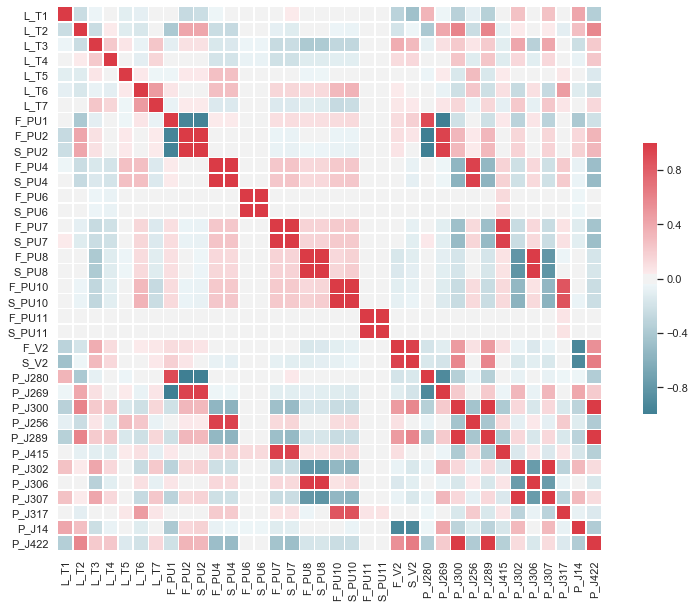

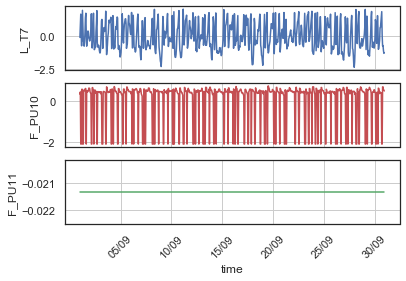

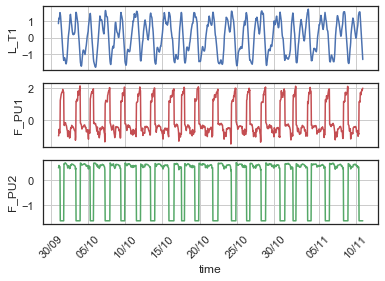

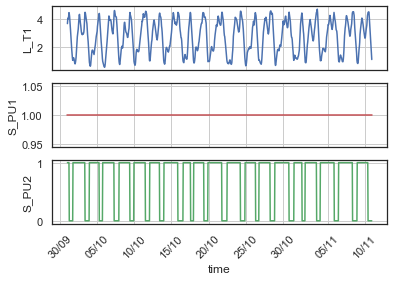

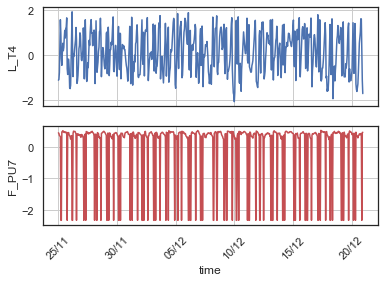

In [31]:
print('Plotting...')
plt.savefig('plots/naive_predictions/autocorrelation_F_PU1.png', bbox_inches='tight')
make_heatmap(train_df1, 'training1', remove_constant=True)
make_lineplot(scaled_df1, ['L_T7', 'F_PU10', 'F_PU11'], 'training1', '2014-09-01', '2014-09-30')
make_lineplot(scaled_df1, ['L_T1', 'F_PU1', 'F_PU2'], 'training1', '2014-10-01', '2014-11-10')
make_lineplot(train_df1, ['L_T1', 'S_PU1', 'S_PU2'], 'training1', '2014-10-01', '2014-11-10')
make_lineplot(scaled_df1, ['L_T4', 'F_PU7'], 'training1', '2014-11-25', '2014-12-20')

## Read and scale training dataset 2 

In [32]:
# training dataset 2 with attack from 04/07/16 00 to 25/12/16 00
print('Reading training dataset 2...')
train_df2 = pd.read_csv('BATADAL_datasets/BATADAL_training_dataset2.csv', index_col=0, parse_dates=[0],
                        date_parser=lambda x: pd.to_datetime(x, format="%d/%m/%y %H"))
print('Applying scaling on the data...')
scaled_df2, train_y2 = scale_and_separate(train_df2)

Reading training dataset 2...
Applying scaling on the data...


## Plots regarding the training dataset 2
### The level tank and flow pressure sensors are selected in a way that the attacks on the training set 2 are reflected

Plotting...


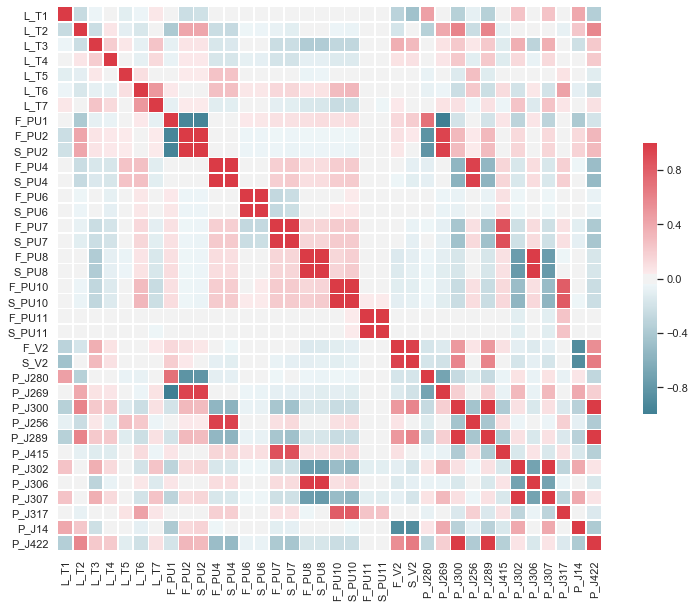

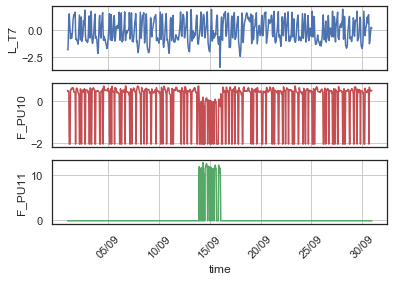

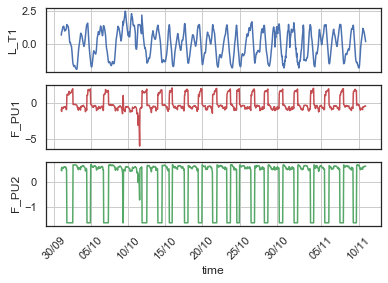

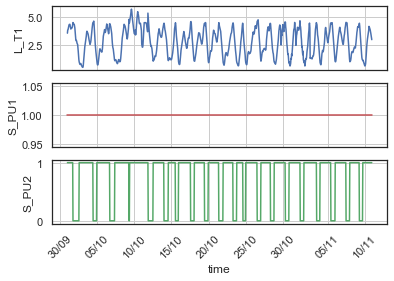

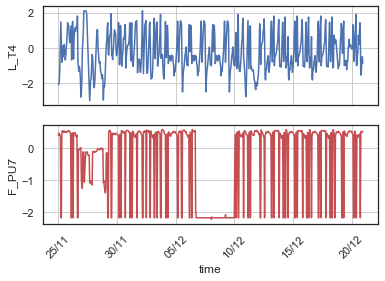

In [33]:
print('Plotting...')
make_heatmap(train_df2, 'training2', remove_constant=True)
make_lineplot(scaled_df2, ['L_T7', 'F_PU10', 'F_PU11'], 'training2', '2016-09-01', '2016-09-30')
make_lineplot(scaled_df2, ['L_T1', 'F_PU1', 'F_PU2'], 'training2', '2016-10-01', '2016-11-10')
make_lineplot(train_df2, ['L_T1', 'S_PU1', 'S_PU2'], 'training2', '2016-10-01', '2016-11-10')
make_lineplot(scaled_df2, ['L_T4', 'F_PU7'], 'training2', '2016-11-25', '2016-12-20')

## Read and scale test dataset 

In [34]:
# test dataset with attacks from 04/01/17 00 to 01/04/17 00
print('Reading the test dataset...')
test_df = pd.read_csv('BATADAL_datasets/BATADAL_test_dataset.csv', index_col=0, parse_dates=[0],
                      date_parser=lambda x: pd.to_datetime(x, format="%d/%m/%y %H"))
print('Applying scaling on the data...')
scaled_test_df, _ = scale_and_separate(test_df, labels=False)

Reading the test dataset...
Applying scaling on the data...


## Plots regarding the test dataset 
### The level tank and flow pressure sensors are selected in a way that the attacks on the test set are reflected

Plotting...


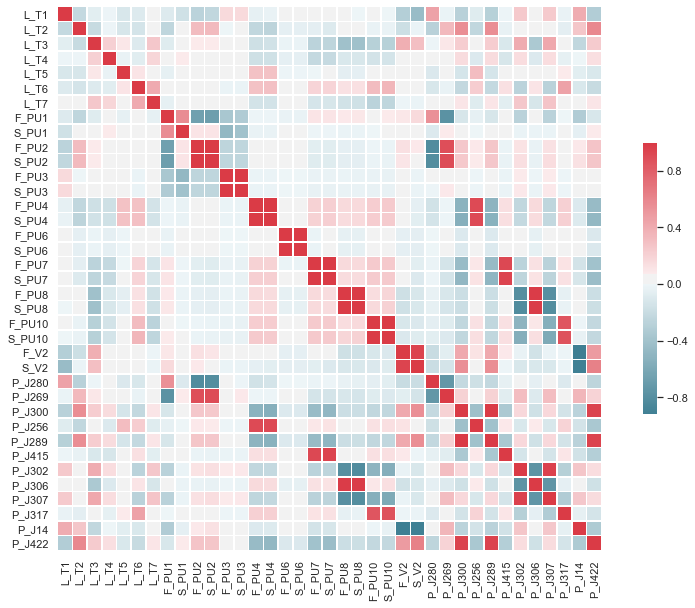

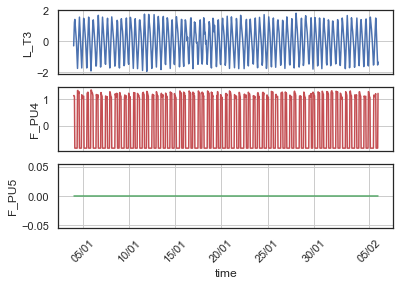

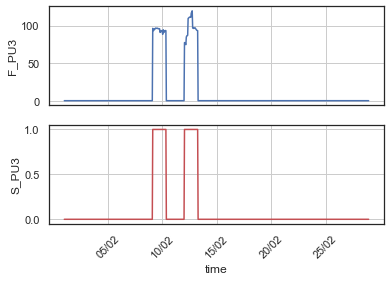

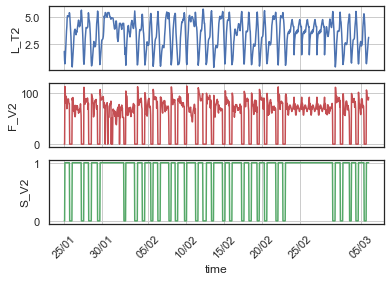

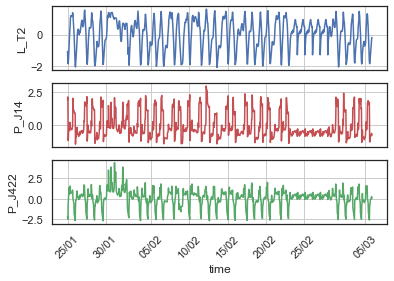

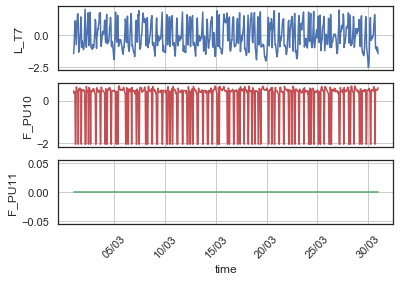

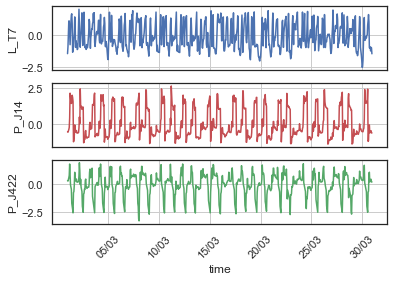

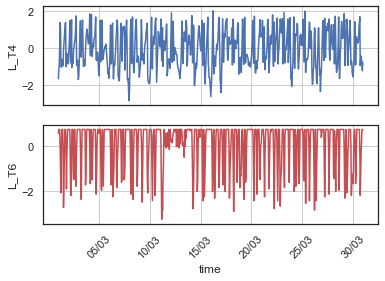

In [35]:
print('Plotting...')
make_heatmap(test_df, 'test', remove_constant=True)
make_lineplot(scaled_test_df, ['L_T3', 'F_PU4', 'F_PU5'], 'test', '2017-01-04', '2017-02-05')
make_lineplot(test_df, ['F_PU3', 'S_PU3'], 'test', '2017-02-01', '2017-02-28')
make_lineplot(test_df, ['L_T2', 'F_V2', 'S_V2'], 'test', '2017-01-25', '2017-03-05')
make_lineplot(scaled_test_df, ['L_T2', 'P_J14', 'P_J422'], 'test', '2017-01-25', '2017-03-05')
make_lineplot(scaled_test_df, ['L_T7', 'F_PU10', 'F_PU11'], 'test', '2017-03-01', '2017-03-30')
make_lineplot(scaled_test_df, ['L_T7', 'P_J14', 'P_J422'], 'test', '2017-03-01', '2017-03-30')
make_lineplot(scaled_test_df, ['L_T4', 'L_T6'], 'test', '2017-03-01', '2017-03-30')

## Correlation Heatmap when all datasets are considered

Plotting the correlation heatmap for the concatenated dataset...


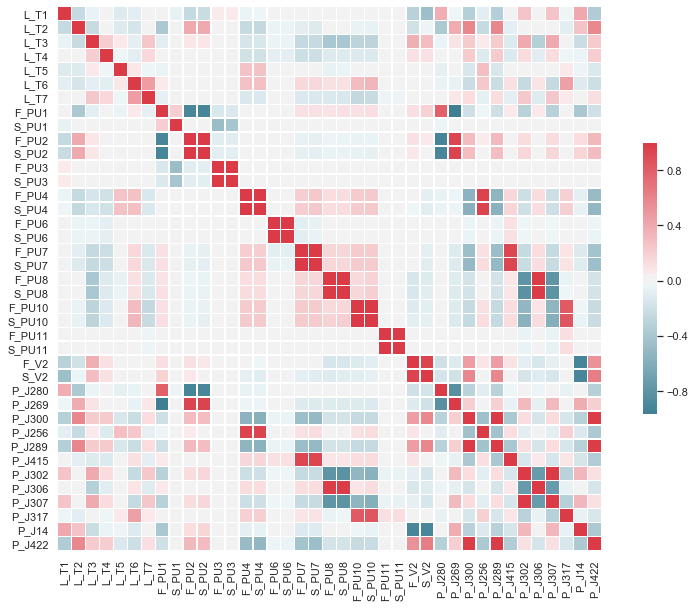

In [36]:
print('Plotting the correlation heatmap for the concatenated dataset...')
make_heatmap(pd.concat([scaled_df1, scaled_df2, scaled_test_df], ignore_index=False), 'all', remove_constant=True)

## Naive Auto-regressive predictor

Making AR predictions
----------------------------------- Feature: L_T1 -----------------------------------
Test MSE: 0.015


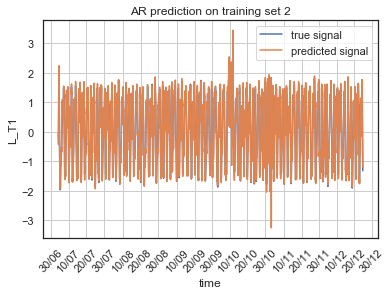

Test MSE: 0.011


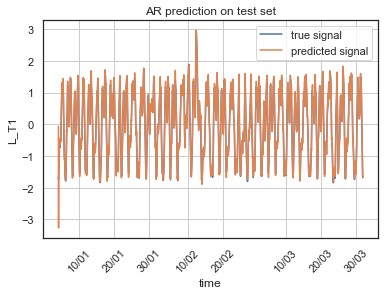

Test MSE: 0.009


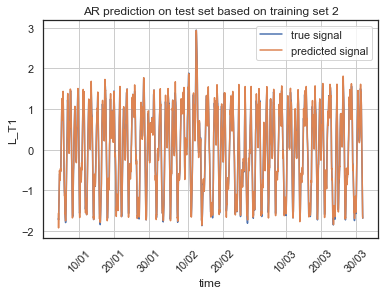

----------------------------------- Feature: L_T3 -----------------------------------
Test MSE: 0.032


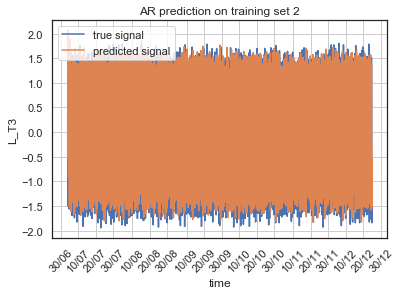

Test MSE: 0.031


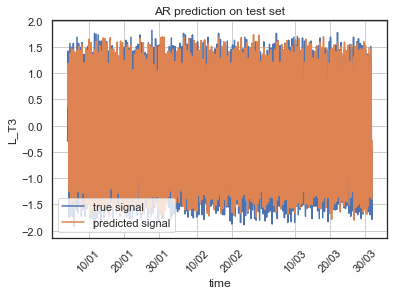

Test MSE: 0.031


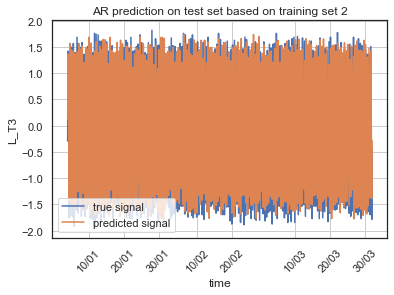

----------------------------------- Feature: L_T4 -----------------------------------
Test MSE: 0.503


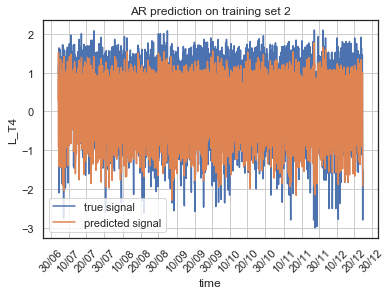

Test MSE: 0.507


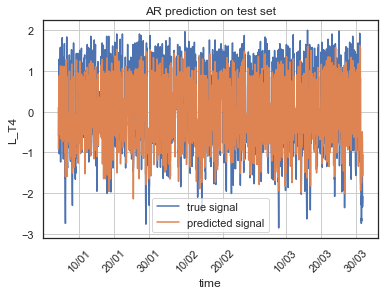

Test MSE: 0.512


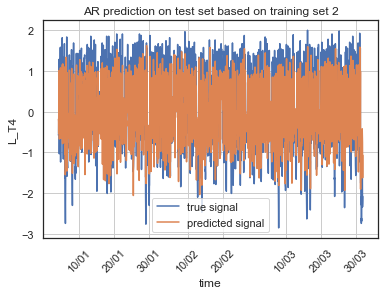

----------------------------------- Feature: L_T7 -----------------------------------
Test MSE: 0.415


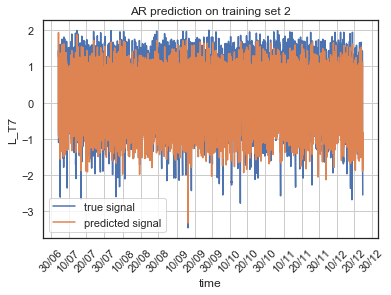

Test MSE: 0.432


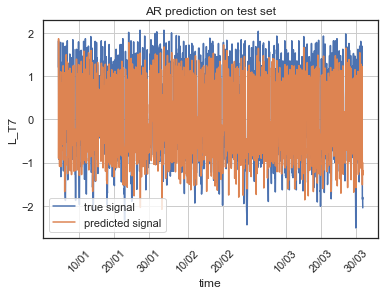

Test MSE: 0.437


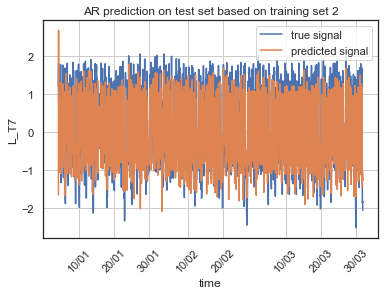

----------------------------------- Feature: F_PU1 -----------------------------------
Test MSE: 0.196


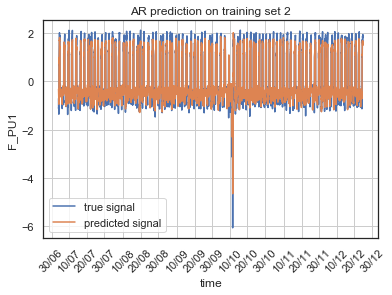

Test MSE: 0.205


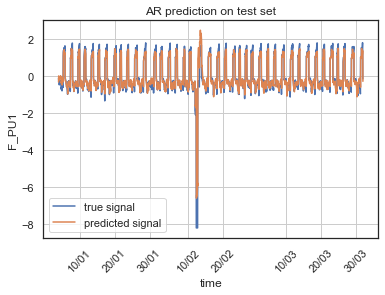

Test MSE: 0.197


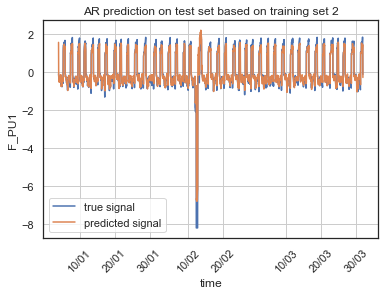

----------------------------------- Feature: F_PU2 -----------------------------------
Test MSE: 0.176


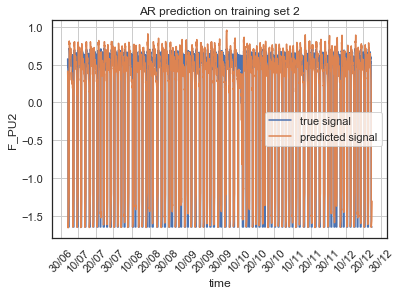

Test MSE: 0.169


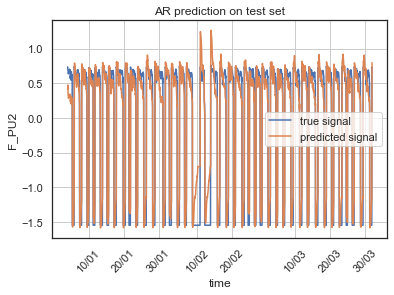

Test MSE: 0.169


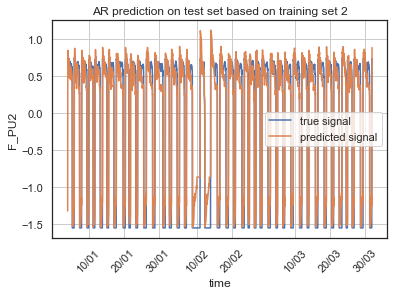

----------------------------------- Feature: F_PU4 -----------------------------------
Test MSE: 0.230


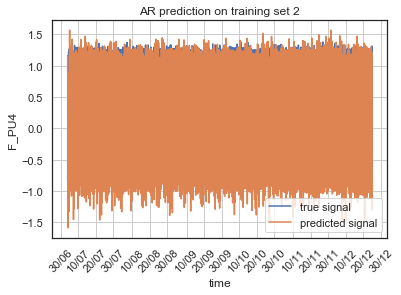

Test MSE: 0.200


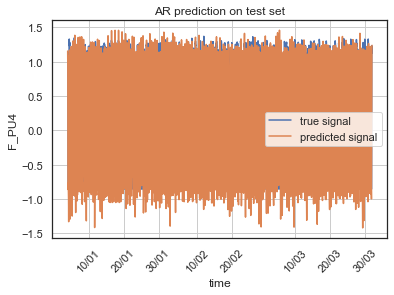

Test MSE: 0.202


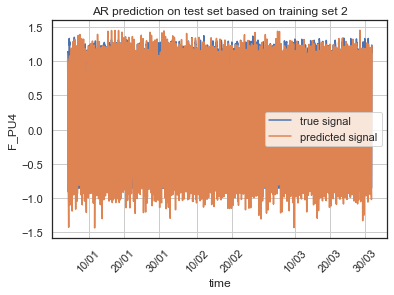

----------------------------------- Feature: F_PU10 -----------------------------------
Test MSE: 0.762


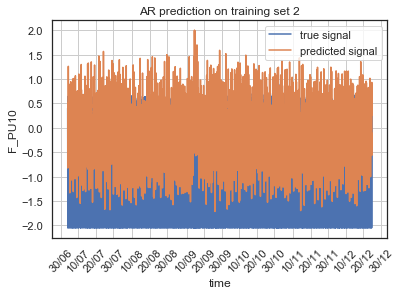

Test MSE: 0.741


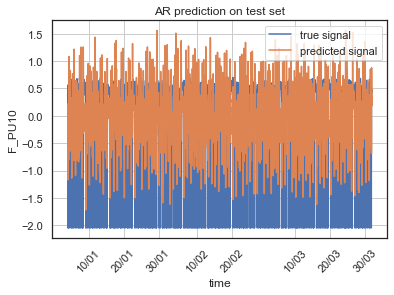

Test MSE: 0.747


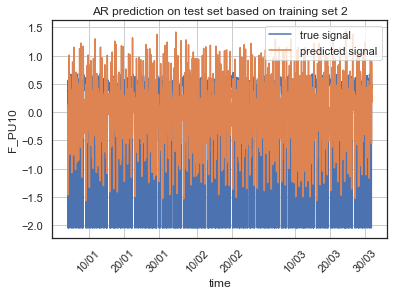

In [37]:
print("Making AR predictions")
use_AR(scaled_df1, scaled_df2, scaled_test_df, ['L_T1', 'L_T3', 'L_T4', 'L_T7', 'F_PU1', 'F_PU2', 'F_PU4', 'F_PU10'])